# Final Project

This project is focused on creating a neural network that will read the size of an abalone, and determine what is the age of that abalone.


In [5]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()

import sklearn.datasets
import sklearn.neural_network
import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.pipeline
import sklearn.model_selection
import sklearn.metrics

import torch
import skorch

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [6]:
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

Importing the dataset of Abalones to the notebook

In [7]:
df_aba = sklearn.datasets.fetch_openml(data_id = 183)
df_aba = pd.DataFrame(sklearn.datasets.fetch_openml(data_id = 183, as_frame = True)['frame'])
df_aba.describe()

C:\Users\scodm\mambaforge\envs\ee5830\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
C:\Users\scodm\mambaforge\envs\ee5830\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000


C:\Users\scodm\mambaforge\envs\ee5830\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


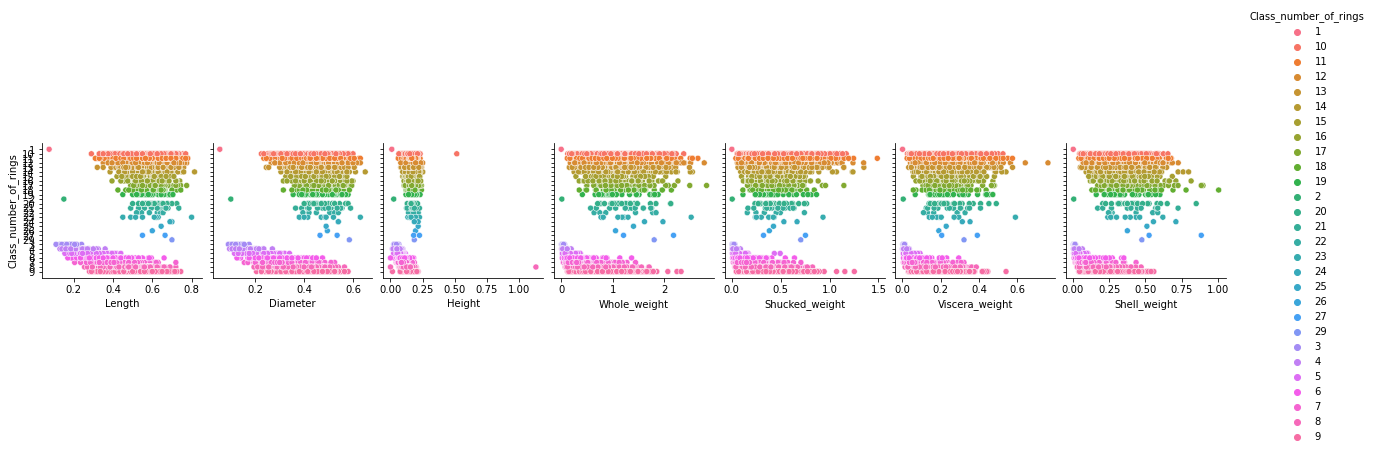

In [8]:
sns.pairplot(df_aba, y_vars='Class_number_of_rings', hue = 'Class_number_of_rings')

## Now I'm going to start implementing a dense network, to see what kind of results I can see come out (REPHRASE THIS BETTER LATER)

In [9]:
X_data = df_aba.drop(columns = ['Class_number_of_rings', 'Sex'])
X_data = X_data.astype(np.float32)
y_data = df_aba['Class_number_of_rings']
y_data = y_data.astype(np.float32)
X_data.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000


In [10]:
y_data.describe()

count    4177.000000
mean        9.933684
std         3.224169
min         1.000000
25%         8.000000
50%         9.000000
75%        11.000000
max        29.000000
Name: Class_number_of_rings, dtype: float64

In [11]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_data, y_data, test_size = 0.2, random_state = 64

)

In [77]:
# class Project_Network(torch.nn.Module): 
#     def __init__(
#         self,
#         n_input_columns: int,
#         hidden_layer_sizes = (100,), 
#         act_func = torch.nn.functional.relu, # relu, tanh, sigmoid
#     ):

#         super().__init__()
#         self.hidden_layer_sizes = hidden_layer_sizes
#         self.act_func = act_func

#         self.dense = torch.nn.Linear(
#             n_input_columns,
#             self.hidden_layer_sizes[0]
#         )
#         self.output = torch.nn.Linear(int(self.hidden_layer_sizes[0]), 1)

#     def forward(self, X, **kwargs):
#         X = self.act_func(self.dense(X))
#         X = self.output(X)
#         return X




In [137]:
class Project_Network(torch.nn.Module):
    def __init__(
            self,
            n_input_channels: int,
            n_output_probs: int,
            
            act_fn_maxpool=torch.nn.functional.relu,
            dense_layer_sizes=(100, 100,),  # only for hidden layers
            act_fn_dense=torch.nn.functional.relu,
            #dropout=0.5
    ):
        super().__init__()
        self.act_fn_maxpool = act_fn_maxpool #I'm not using maxpool anymore it seems
        self.dense_layer_sizes = dense_layer_sizes
        self.act_fn_dense = act_fn_dense
        
       

        # Dense network
        self.dense_network = torch.nn.ModuleList()
        self.dense_network.append(
            torch.nn.Linear(
                n_input_channels, # originally was- self.calc_dense_n_inputs(),
                self.dense_layer_sizes[0]))
        
        # Rest of the Dense network
        for layer_size in self.dense_layer_sizes:
            self.dense_network.append(
                torch.nn.Linear(
                    layer_size,
                    layer_size,
                )
            )
            
        self.output = torch.nn.Linear(self.dense_layer_sizes[0], 1)

    # def calc_dense_n_inputs(self):
    #     """
    #     Assume no padding, 1 dilation, 1 stride in Conv2d layers.
    #     Assume no padding, 1 dilation, kernel size 2 in MaxPool2d layers.

    #     :returns: number of inputs into the dense (FC or Linear) network
    #     """      
    #     final_size = self.input_img_height
    #     for conv_kernel_size in self.conv_kernel_sizes:
    #         final_size = np.floor(final_size - (conv_kernel_size - 1))  # conv2d
    #         final_size = np.floor((final_size - (2-1) - 1)/2 + 1)  # maxpool2d
    #     return int(self.conv_layer_sizes[-1] * np.square(final_size))


    def forward(self, X, **kwargs):
        # for layer in self.conv_network:
        #     if isinstance(layer, torch.nn.MaxPool2d):
        #         X = self.act_fn_maxpool(layer(X))
        #     else:
        #         X = layer(X)
        
        # X = X.view(-1, X.size(1) * X.size(2) * X.size(3))

        #the above p
        for layer in self.dense_network:
            X = self.act_fn_dense(layer(X))
            
        return torch.nn.functional.softmax(X, dim=-1)

In [138]:
n_orig_features = 7

# list of tuples is the pipeline path in the end
pipeline_aba_steps = [ 
    ("polyfeatures", sklearn.preprocessing.PolynomialFeatures(
        degree = 2, 
        include_bias = True
    )),
    ("selector", sklearn.feature_selection.SelectKBest(
        score_func = sklearn.feature_selection.mutual_info_regression,
        k = n_orig_features
    )),
    ("scaler", sklearn.preprocessing.RobustScaler( )), #RobustScaler, MinMaxScaler
    ("network", skorch.NeuralNetRegressor(
        Project_Network,
        optimizer = torch.optim.Adam, # Adam, SGD instead
        lr = 0.2,
        max_epochs = 50,
        callbacks = [skorch.callbacks.EarlyStopping( # trying out early stopping
            patience = 20)]
    ))
]

pipeline_aba = sklearn.pipeline.Pipeline(pipeline_aba_steps)

In [139]:
# pipeline_aba.named_steps["network"].module__n_input_columns = n_orig_features
# pipeline_aba.named_steps["network"].module__hidden_layer_sizes = (
#     40,
# )
aba_n_outputs = len(np.unique(y_data))

pipeline_aba.named_steps["network"].module__n_input_channels = 1
pipeline_aba.named_steps["network"].module__n_output_probs = aba_n_outputs


In [140]:
pipeline_aba.fit(X_data, y_data)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x7 and 1x50)

In [89]:
pipeline_aba.score(X_test, y_test)

-0.025402057859795102

In [90]:
y_data.value_counts()

Class_number_of_rings
9.0     689
10.0    634
8.0     568
11.0    487
7.0     391
12.0    267
6.0     259
13.0    203
14.0    126
5.0     115
15.0    103
16.0     67
17.0     58
4.0      57
18.0     42
19.0     32
20.0     26
3.0      15
21.0     14
23.0      9
22.0      6
27.0      2
24.0      2
1.0       1
26.0      1
29.0      1
2.0       1
25.0      1
Name: count, dtype: int64

### This part is looking at what the predicted values are

In [92]:
aba_y_pred = pipeline_aba.predict(X_test)
aba_y_pred = aba_y_pred.astype(np.int32)
aba_y_pred

array([[ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 9],

In [93]:
y_array_test = y_test.to_numpy()
y_array_test = y_array_test.transpose()
y_array_test
#y_array_test2 = []

#for num in range(y_array_test):
    

array([13., 13.,  8.,  8., 17.,  7., 14., 10.,  4.,  9.,  8.,  9.,  9.,
       14.,  9.,  8.,  8., 10.,  9., 13., 10.,  7.,  9., 10., 13.,  8.,
        9.,  8.,  8.,  9., 11., 11.,  4.,  8., 10., 12., 10., 18.,  6.,
        5., 10., 10.,  8., 15., 11., 16.,  9., 12., 10., 16., 15.,  8.,
        9., 10., 11., 11.,  9., 12., 12., 10., 11.,  4.,  7.,  8.,  9.,
       13.,  9., 11., 16.,  6., 10.,  7., 10.,  7.,  8., 14., 14., 10.,
        8.,  8.,  9.,  8.,  8., 13.,  8.,  8.,  5., 10., 16., 14., 11.,
        8., 11.,  7.,  7., 11., 10., 11.,  8., 10.,  6., 15.,  9., 10.,
        8.,  9., 10.,  6.,  6., 11.,  5., 16.,  8.,  9.,  7.,  9.,  7.,
       16.,  7.,  9.,  9.,  9., 11., 10., 10., 11.,  9.,  9.,  8., 12.,
       10.,  8., 10.,  8.,  9.,  9., 10., 10.,  8.,  8., 17., 15., 15.,
       11.,  8., 11., 10., 11., 12., 10.,  8.,  7.,  7.,  6., 10., 13.,
        5.,  8.,  8., 14.,  8., 23.,  8.,  8.,  9.,  9., 14.,  7., 20.,
       11., 10., 11., 16., 11., 11., 13.,  9.,  7., 20.,  7., 10

In [94]:
df_pred = pd.DataFrame.from_dict(
    {
        'y_pred': aba_y_pred[:, 0],
        'y_act': y_array_test,
    }
)
df_pred

,y_pred,y_act
0,9,13.0
1,9,13.0
2,9,8.0
3,9,8.0
4,9,17.0
...,...,...
831,9,9.0
832,9,5.0
833,9,15.0
834,9,10.0


In [95]:
df_pred['y_pred'].value_counts()

y_pred
9     835
10      1
Name: count, dtype: int64

C:\Users\scodm\mambaforge\envs\ee5830\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


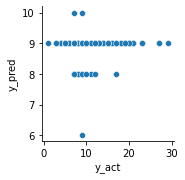

In [76]:
sns.pairplot(df_pred, y_vars='y_pred', x_vars='y_act')

## Damn this graph is ass as hell, I don't like this at all

## Terrible terrible score, we shouldn't use this

#### Ways to modify project to give a better score
- Find out how many instances there are for each classification  [X]
- graph the predicted and the actual y on a plot
- try using more hidden layers for the project, there are different ways to set that up so be careful
- Don't use regression? Use something else down the line?